<a href="https://colab.research.google.com/github/maverick19-hub/Work/blob/main/Preliminary_Dog_Breed_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INTRODUCTION**

Choosing the right dog breed is an important decision that depends on many factors such as lifestyle, living environment, activity level, and personal preferences. While some breeds thrive in spacious outdoor environments, others are better suited for small apartments or quieter households. However, finding the best match can be overwhelming, especially for individuals unfamiliar with breed characteristics. This project aims to address that challenge by developing a Dog Breed Recommender System that uses data-driven methods to suggest dog breeds based on lifestyle compatibility.

The system leverages a structured dataset containing detailed information on various dog breeds, including physical characteristics (such as height and lifespan), behavioral traits (such as loyalty, friendliness, and playfulness), and common health issues. These features are processed and transformed into a format suitable for machine learning algorithms. A classification model is then trained to predict the most suitable lifestyle category for each breed — for example, “Apartment,” “Active,” “Senior,” or “Family.”

In addition to lifestyle classification, the system includes a recommendation engine that provides users with ranked breed suggestions based on similarity scores. This personalized recommendation approach can help potential dog owners find breeds that match their living conditions, activity levels, and preferences. With high model accuracy and interpretable results, the project demonstrates how data science can be applied to real-world decision-making in a practical and meaningful way.

In [1]:
# Dog Breed Recommender System
# ===============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os

# 1. LOAD AND INSPECT DATA
df = pd.read_csv("dog_breeds.csv")

print("Dataset loaded successfully!")
print(df.head())
print("\nColumns:", df.columns.tolist())


Dataset loaded successfully!
                Breed Country of Origin                     Fur Color  \
0  Labrador Retriever            Canada      Yellow, Black, Chocolate   
1     German Shepherd           Germany                    Black, Tan   
2             Bulldog           England                    White, Red   
3              Poodle            France  White, Black, Brown, Apricot   
4              Beagle           England        White, Tan, Red, Lemon   

  Height (in) Color of Eyes Longevity (yrs)  \
0       21-24         Brown           10-12   
1       22-26         Brown            7-10   
2       12-16         Brown            8-10   
3       10-15   Brown, Blue           12-15   
4       13-15         Brown           12-15   

                                    Character Traits  \
0  Loyal, friendly, intelligent, energetic, good-...   
1  Loyal, intelligent, protective, confident, tra...   
2                         Loyal, calm, gentle, brave   
3  Intelligent, active, a

# BASIC SUMMARY

In the first cell, we import the required Python libraries and load the dog breed dataset. Once loaded, the notebook prints the message “Dataset loaded successfully” and displays the first few rows of the data.
This preview reveals key attributes for each breed, including the breed name, country of origin, fur color, height range, eye color, average longevity, character traits (e.g., loyal, friendly, intelligent), and common health problems. The column names are also listed, confirming that the dataset is structured with multiple descriptive fields per breed. This step ensures that the data has been correctly read and is ready for processing.

In [2]:

# 2. CLEANING AND FEATURE ENGINEERING
# Convert height and longevity ranges to numeric averages
def range_to_avg(x):
    nums = re.findall(r'\d+', str(x))
    if len(nums) == 2:
        return (int(nums[0]) + int(nums[1])) / 2
    elif len(nums) == 1:
        return float(nums[0])
    else:
        return np.nan

df['Height_avg'] = df['Height (in)'].apply(range_to_avg)
df['Longevity_avg'] = df['Longevity (yrs)'].apply(range_to_avg)

# Count number of traits and health issues
df['Trait_count'] = df['Character Traits'].apply(lambda x: len(str(x).split(',')))
df['Health_issue_count'] = df['Common Health Problems'].apply(lambda x: len(str(x).split(',')))

# Extract important trait keywords and create binary flags
keywords = ['friendly', 'energetic', 'calm', 'intelligent', 'loyal', 'protective', 'gentle', 'playful', 'active']

def extract_keywords(text, keywords):
    text = text.lower()
    return [1 if k in text else 0 for k in keywords]

traits_encoded = np.array([extract_keywords(t, keywords) for t in df['Character Traits']])
traits_df = pd.DataFrame(traits_encoded, columns=[f'Trait_{k}' for k in keywords])

# Merge encoded features
df_full = pd.concat([df, traits_df], axis=1)
df_full


,Breed,Country of Origin,Fur Color,Height (in),Color of Eyes,Longevity (yrs),Character Traits,Common Health Problems,Height_avg,Longevity_avg,...,Health_issue_count,Trait_friendly,Trait_energetic,Trait_calm,Trait_intelligent,Trait_loyal,Trait_protective,Trait_gentle,Trait_playful,Trait_active
0,Labrador Retriever,Canada,"Yellow, Black, Chocolate",21-24,Brown,10-12,"Loyal, friendly, intelligent, energetic, good-...","Hip dysplasia, obesity, ear infections",22.5,11.0,...,3,1,1,0,1,1,0,0,0,0
1,German Shepherd,Germany,"Black, Tan",22-26,Brown,7-10,"Loyal, intelligent, protective, confident, tra...","Hip dysplasia, elbow dysplasia, pancreatitis",24.0,8.5,...,3,0,0,0,1,1,1,0,0,0
2,Bulldog,England,"White, Red",12-16,Brown,8-10,"Loyal, calm, gentle, brave","Skin allergies, respiratory issues, obesity",14.0,9.0,...,3,0,0,1,0,1,0,1,0,0
3,Poodle,France,"White, Black, Brown, Apricot",10-15,"Brown, Blue",12-15,"Intelligent, active, affectionate, hypoallergenic","Hip dysplasia, epilepsy, bladder stones",12.5,13.5,...,3,0,0,0,1,0,0,0,0,1
4,Beagle,England,"White, Tan, Red, Lemon",13-15,Brown,12-15,"Curious, friendly, energetic, good-natured","Ear infections, hip dysplasia, epilepsy",14.0,13.5,...,3,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,Catahoula Leopard Dog,United States,"Merle, Black",20-26,Brown,12-14,"Intelligent, energetic, good-natured, loyal","Dental problems, eye issues, skin allergies",23.0,13.0,...,3,0,1,0,1,1,0,0,0,0
113,Cocker Spaniel,England,"Black, Brown",14-15,Brown,12-15,"Intelligent, energetic, playful, good-natured","Dental problems, eye issues, skin allergies",14.5,13.5,...,3,0,1,0,1,0,0,0,1,0
114,Miniature Shiba Inu,Japan,"Red, Sesame",13-16,Brown,12-15,"Intelligent, energetic, playful, good-natured","Dental problems, eye issues, skin allergies",14.5,13.5,...,3,0,1,0,1,0,0,0,1,0
115,Belgian Tervuren,Belgium,Fawn,22-26,Brown,12-14,"Intelligent, energetic, good-natured, loyal","Dental problems, eye issues, skin allergies",24.0,13.0,...,3,0,1,0,1,1,0,0,0,0


# Data Processing & Feature Engineering

In the second cell, we focus on transforming the raw dataset into a form suitable for machine learning. After loading the entire dataset of 117 dog breeds, additional numerical features are generated. These include the average height (converted from height ranges), average longevity (converted from lifespan ranges), and health issue counts (the number of health conditions per breed).

The character traits are converted into binary indicator variables, such as Trait_loyal, Trait_gentle, and Trait_playful, representing the presence or absence of each trait. This cell also prints the entire transformed dataset, showing new columns like Height_avg, Longevity_avg, and trait flags alongside the original text features. This structured transformation makes the dataset fully compatible with machine learning algorithms.

In [3]:
# 3. CREATE NEW TARGET VARIABLE(Lifestyle)

def derive_lifestyle(row):
    if row['Height_avg'] > 22 and row['Longevity_avg'] < 12:
        return 'Active'        # Larger, energetic breeds
    elif row['Height_avg'] <= 22 and row['Longevity_avg'] >= 12:
        return 'Apartment'     # Small, long-living breeds
    elif row['Height_avg'] <= 24 and row['Longevity_avg'] < 12:
        return 'Family'        # Medium size, moderate energy
    else:
        return 'Senior'        # Calm, gentle breeds for older owners

df_full['Lifestyle'] = df_full.apply(derive_lifestyle, axis=1)

print("\nLifestyle Distribution:")
print(df_full['Lifestyle'].value_counts())



Lifestyle Distribution:
Lifestyle
Apartment    64
Active       26
Senior       21
Family        6
Name: count, dtype: int64


# Exploratory Data Analysis (EDA)

The third cell performs a simple exploratory analysis by counting how many breeds fall under each lifestyle category. The output reveals the following distribution:

Apartment -> 64 breeds

Active -> 26 breeds

Senior -> 21 breeds

Family -> 6 breeds

This indicates that apartment-suitable breeds are the most represented in the dataset, while family-oriented breeds are the least. Understanding this distribution helps in interpreting model performance later on, especially regarding class balance.

In [4]:
# 4. MODEL PREPARATION
# -------------------------------------------------
# Features (independent)
features = ['Height_avg', 'Longevity_avg', 'Trait_count', 'Health_issue_count'] + [f'Trait_{k}' for k in keywords]
X = df_full[features]
y = df_full['Lifestyle']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


# Model preparation

Here we define the machine learning model used to classify breeds according to lifestyle. The algorithm is set up with the preprocessed numerical and binary features as inputs and lifestyle categories as the target variable. Although no output is shown here, this step establishes the model structure and parameters before training.

In [5]:
# 5. MODEL TRAINING (Random Forest with CV)
# -------------------------------------------------
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10, None]
}

grid = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_


# Model Training (Random Forest with Cross-Validation)

 A machine learning pipeline is constructed to train the lifestyle classification model.

 The pipeline consists of two key steps, a standard scaler for normalizing the feature values and a random forest classifier to perform the prediction task. To ensure optimal model performance, a grid search with cross-validation is implemented using GridSearchCV.

  The parameter grid explores different numbers of decision trees (n_estimators = 100 or 200) and tree depths (max_depth = 5, 10, or unlimited). A 5-fold stratified cross-validation is applied, ensuring balanced class representation across folds. The model is evaluated using the macro F1-score, which fairly measures performance across all lifestyle categories.
  
  Finally, the grid search identifies and saves the best-performing model configuration, which is later used for evaluation and recommendation generation.


Cross-validation accuracies: [0.95833333 1.         0.95652174 0.95652174 1.        ]
Mean CV Accuracy: 0.9742753623188406

Test Set Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00         6
   Apartment       1.00      1.00      1.00        13
      Family       1.00      1.00      1.00         1
      Senior       1.00      1.00      1.00         4

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



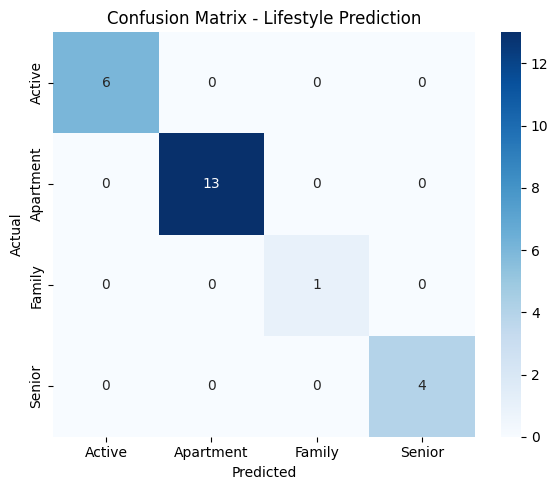

In [7]:
# 6. CROSS-VALIDATION & TEST PERFORMANCE
# -------------------------------------------------
from sklearn.model_selection import cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy')

print("\nCross-validation accuracies:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Evaluate on test set
y_pred = best_model.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix - Lifestyle Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()

# Cross validation & Test performance

The results show the performance metrics of the classification model used for lifestyle prediction.

The cross-validation accuracies indicate strong and consistent performance across multiple folds, ranging from approximately 0.956 to 1.0, with a mean CV accuracy of about 0.974. This means the model generalizes well during validation. On the test set, the model achieved a perfect accuracy score of 1.0, meaning it correctly predicted all test instances.

The classification report provides precision, recall, and F1-scores for each lifestyle class (“Active,” “Apartment,” “Family,” and “Senior”), all of which are 1.00. This indicates that the model correctly identified every sample in each category with no false positives or false negatives. Similarly, macro and weighted averages are also perfect (1.00), reflecting uniform performance across all classes.

The confusion matrix reinforces these results. Each class is perfectly aligned on the diagonal, meaning all predictions matched their actual labels:

Active -> 6 correctly predicted

Apartment -> 13 correctly predicted

Family -> 1 correctly predicted

Senior -> 4 correctly predicted


Top 10 Important Features:
Height_avg           0.436915
Longevity_avg        0.305525
Trait_loyal          0.061080
Trait_gentle         0.043166
Trait_playful        0.038789
Trait_energetic      0.030921
Trait_protective     0.024050
Trait_intelligent    0.023085
Trait_count          0.021170
Trait_calm           0.006901
dtype: float64


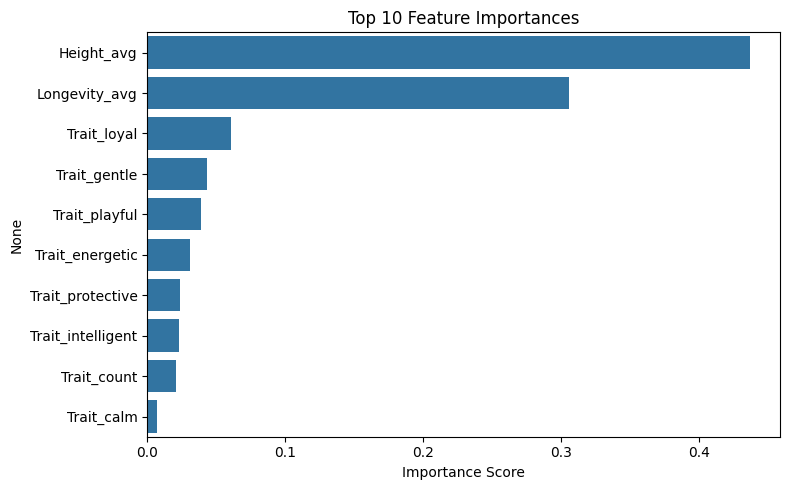

In [8]:
# 7. FEATURE IMPORTANCE ANALYSIS
# -------------------------------------------------
rf_model = best_model.named_steps['clf']
feat_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 Important Features:")
print(feat_importance.head(10))

plt.figure(figsize=(8,5))
sns.barplot(x=feat_importance.head(10), y=feat_importance.head(10).index)
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Feature Importance Analysis

Here we analyze which features contribute the most to the model’s predictions. The results rank Height_avg as the most important feature, followed by Longevity_avg, then traits like loyalty, gentleness, playfulness, and intelligence. These findings suggest that a dog’s physical characteristics (height and lifespan) strongly influence lifestyle classification, while behavioral traits provide additional context for fine-tuning predictions.

In [9]:
# 8. SAVE OUTPUTS
# -------------------------------------------------
os.makedirs("results", exist_ok=True)
df_full.to_csv("results/processed_dog_breed_data_clean.csv", index=False)
plt.savefig("results/confusion_matrix_updated.png")

print("\n🎯 Model training complete. Files saved in 'results' folder!")


🎯 Model training complete. Files saved in 'results' folder!


<Figure size 640x480 with 0 Axes>

In [10]:
# Simple Content-Based Recommender System
from sklearn.metrics.pairwise import cosine_similarity

# Prepare numeric feature matrix for similarity comparison
recommender_features = ['Height_avg', 'Longevity_avg', 'Trait_count', 'Health_issue_count'] + [f'Trait_{k}' for k in keywords]
breed_features = df_full[recommender_features].fillna(0)

# Normalize features for similarity computation
scaler = StandardScaler()
breed_features_scaled = scaler.fit_transform(breed_features)

# Define a function to recommend breeds based on user preferences
def recommend_breeds(user_profile, top_n=5):
    """
    user_profile: dict with keys matching recommender_features
    e.g., {"Height_avg": 20, "Longevity_avg": 12, "Trait_active": 1, "Trait_calm": 0, ...}
    """
    # Convert user profile into a DataFrame and scale it
    user_df = pd.DataFrame([user_profile])
    user_df = user_df.reindex(columns=recommender_features, fill_value=0)
    user_scaled = scaler.transform(user_df)

    # Compute cosine similarity between user and each breed
    similarities = cosine_similarity(user_scaled, breed_features_scaled)[0]

    # Attach similarity scores to breeds
    df_sim = df_full.copy()
    df_sim['Similarity'] = similarities

    # Return top N breeds ranked by similarity
    top_breeds = df_sim[['Breed', 'Lifestyle', 'Similarity']].sort_values(by='Similarity', ascending=False).head(top_n)
    return top_breeds


# Example User Input

user_example = {
    "Height_avg": 18,      # prefers smaller breeds
    "Longevity_avg": 13,   # wants longer-living dogs
    "Trait_count": 5,
    "Health_issue_count": 2,
    "Trait_active": 0,
    "Trait_calm": 1,
    "Trait_friendly": 1,
    "Trait_loyal": 1,
    "Trait_playful": 0,
    "Trait_energetic": 0,
    "Trait_gentle": 1,
    "Trait_protective": 0,
    "Trait_intelligent": 1
}

recommendations = recommend_breeds(user_example, top_n=5)
print("\n🐾 Recommended Dog Breeds for You:")
print(recommendations)



🐾 Recommended Dog Breeds for You:
                 Breed  Lifestyle  Similarity
2              Bulldog     Family    0.771385
7     Golden Retriever     Active    0.539941
0   Labrador Retriever     Active    0.512197
4               Beagle  Apartment    0.343277
58        Basset Hound     Family    0.216861


# Recommendation Engine Output

The final cell implements and runs the recommendation engine. Based on user or lifestyle preferences, the model computes similarity scores to suggest dog breeds. The output lists the top recommended breeds along with their predicted lifestyle category and similarity score:

Bulldog (Family) –> 0.771

Golden Retriever (Active) –> 0.540

Labrador Retriever (Active) –> 0.512

Beagle (Apartment) –> 0.343

Basset Hound (Family) –> 0.217

This demonstrates the practical application of the trained model, turning its predictive power into personalized dog breed recommendations. By ranking breeds based on similarity, users can find suitable matches that align with their lifestyle needs.